# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is the csv

## 02 - Load Data and Plot Time Series
Let's start by loading the time series of the challenge and plot the time series

       Month  Sales
0    1964-01   2815
1    1964-02   2672
2    1964-03   2755
3    1964-04   2721
4    1964-05   2946
..       ...    ...
100  1972-05   4618
101  1972-06   5312
102  1972-07   4298
103  1972-08   1413
104  1972-09   5877

[105 rows x 2 columns]


<AxesSubplot: >

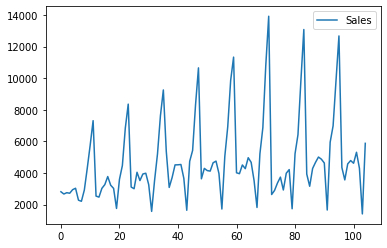

In [1]:
# REMARQUE : j'ai du enlever les guillemets autour des headers dans le fichier CSv
# (le fichier CSV ne fonctionnait pas autrement)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sales_df = pd.read_csv("data/monthly_champagne_sales.csv")
print(sales_df)

sns.lineplot(sales_df)



👉 Convert dataframe with datetime objects as index to make it look like this
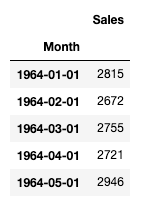

In [2]:
sales_df.index = pd.DatetimeIndex(sales_df["Month"])
sales_df.drop(columns=["Month"], inplace=True)
print(sales_df)

            Sales
Month            
1964-01-01   2815
1964-02-01   2672
1964-03-01   2755
1964-04-01   2721
1964-05-01   2946
...           ...
1972-05-01   4618
1972-06-01   5312
1972-07-01   4298
1972-08-01   1413
1972-09-01   5877

[105 rows x 1 columns]


## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

<AxesSubplot: xlabel='Month'>

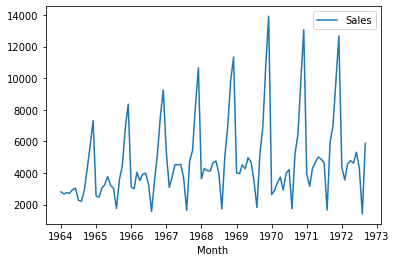

In [3]:
sns.lineplot(sales_df)

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

Modèle additif :


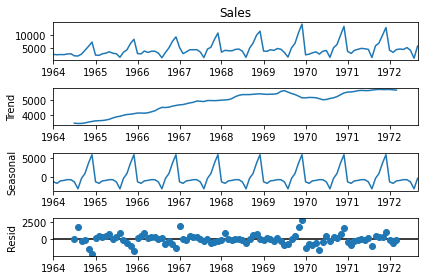

In [4]:

from statsmodels.tsa.seasonal import seasonal_decompose

print("Modèle additif :")
result = seasonal_decompose(sales_df["Sales"], model='additive', period=12)
result.plot();

Modèle multiplicatif :


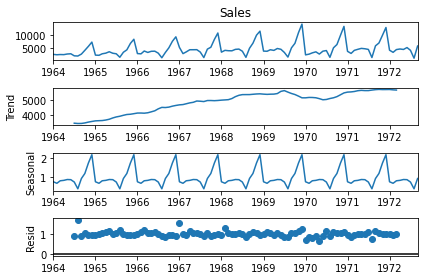

In [5]:
print("Modèle multiplicatif :")
result_mul = seasonal_decompose(sales_df["Sales"], model='multiplicative', period=12)
result_mul.plot();

👉 De-seasonalize this time serie using the decomposition of your choice

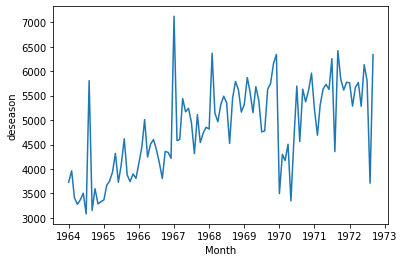

In [6]:
sales_df["deseason"] = sales_df["Sales"].values/result_mul.seasonal
sns.lineplot(sales_df, x=sales_df.index, y="deseason");

☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [7]:
if "deseason" in sales_df.columns: sales_df.drop(columns=["deseason"], inplace=True)
df_train = sales_df.query("index < 1971")
df_test = sales_df.query("index >= 1971")


## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [8]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(sales_df["Sales"])
print(f"p-value: {results[1]}")

p-value: 0.36391577166024586


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

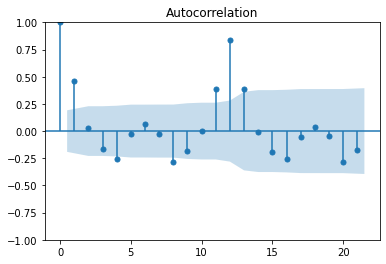

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(sales_df["Sales"]);

### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

p-value après la différenciation saisonnière : 2.0605796968136632e-11


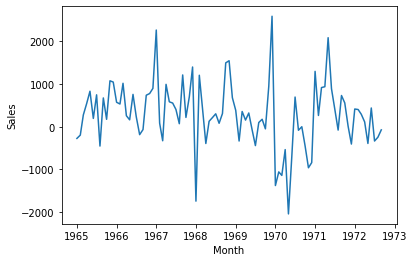

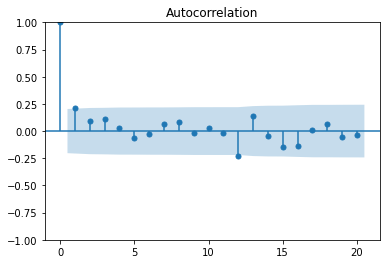

In [10]:
diff = sales_df["Sales"].diff(12).dropna()
results = adfuller(diff)
print(f"p-value après la différenciation saisonnière : {results[1]}")
sns.lineplot(diff);
plot_acf(diff);


☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

p-value après la deuxième différenciation : 0.0002650462849293455


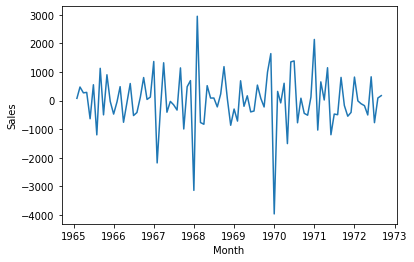

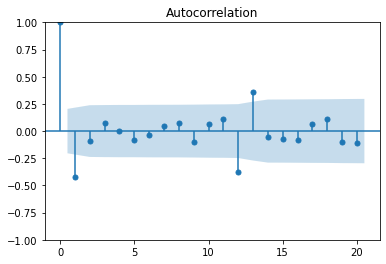

In [11]:
diff_2 = diff.diff().dropna()
results = adfuller(diff_2)
print(f"p-value après la deuxième différenciation : {results[1]}")
sns.lineplot(diff_2);
plot_acf(diff_2);

👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

/home/vincent/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


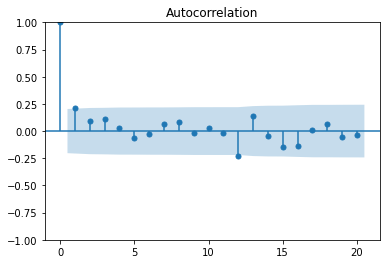

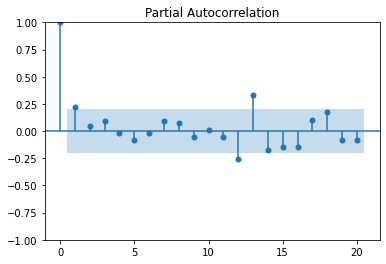

In [12]:
plot_acf(diff);
plot_pacf(diff);

☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [13]:
import pmdarima as pm

model = pm.auto_arima(y=df_train, 
                           start_p=0, 
                           start_q=0, 
                           max_p=2,
                           max_q=2, 
                           d=0,
                           max_d=0,
                           D=1,
                           m=12,
                           start_P=0,
                           start_Q=0,
                           max_P=2,
                           max_Q=2,
                           seasonal=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           njobs=-1,
                           trace=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1169.871, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1171.619, Time=0.64 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1171.569, Time=5.27 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1174.921, Time=0.11 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1171.871, Time=0.48 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1171.871, Time=0.91 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1173.871, Time=0.59 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1169.907, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1169.936, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1171.947, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 8.241 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   84
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -582.935
Date:                  Wed, 08 Mar 2023   AIC                           1169.871
Time:                          12:38:59   BIC                           1174.424
Sample:                      01-01-1964   HQIC                          1171.683
                           - 12-01-1970                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    254.7361     93.821      2.715      0.007      70.851     438.621
sigma2      6.308e+05   8.33e+04      7.570      0.000    4.67e+05    7.94e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.30   Jarque-Bera (JB):                 4.49
Prob(Q):                              0.07   Prob(JB):                         0.11
Heteroskedasticity (H):               4.42   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [14]:
y_pred, conf_int = model.predict(n_periods=len(df_test), return_conf_int=True)
y_df = pd.DataFrame(y_pred, columns=["central"])
y_df["lower"] = conf_int[:,0]
y_df["upper"] = conf_int[:,1]


👇 Run the cell below to plot your predictions against reality

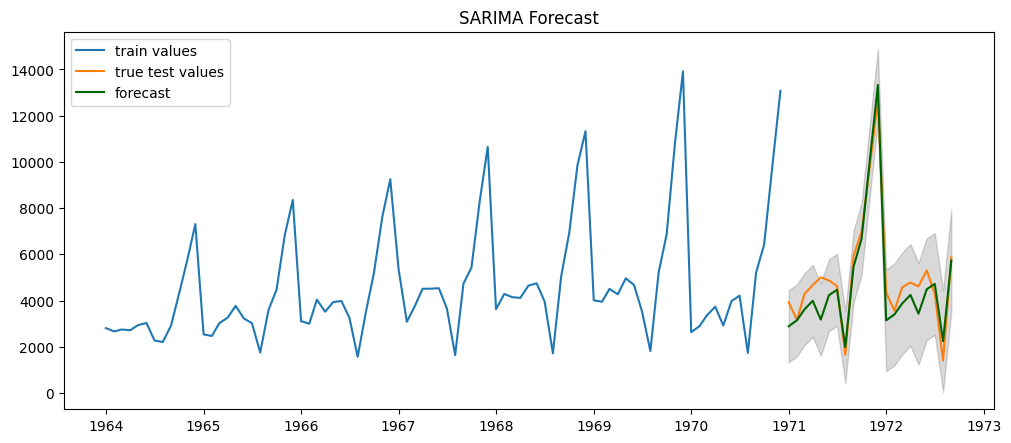

In [15]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(y_df["central"], color='darkgreen',label = "forecast")
plt.fill_between(y_df.index, 
                 y_df["lower"], 
                 y_df["upper"], 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

# Machine Learning Approach

### Model with forecast horizon = 1 month only

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [31]:
df = sales_df.copy()

In [32]:
import numpy as np

# Add lagged values
for month in range(1, 13):
    column_name = f"yt-{month}"
    df[column_name] = df["Sales"].shift(month)

    
# Drop nan
df.dropna(inplace=True)


# create df_train and df_test 
df_train = df.query("index < 1971")
df_test = df.query("index >= 1971")

df.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

train_index = df_train.index.values
test_index = df_test.index.values

test_index = np.array(test_index+len(train_index))



print(train_index)
print(test_index)



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
[72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]


In [33]:
# Create X, y
X = df.drop(columns=["Sales"])
y = df["Sales"]

👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

In [34]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=20, 
                             max_depth=5, 
                             random_state=42)


👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [35]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [36]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_index,
                                                         predictor=regr, full_X = X.values)

In [37]:
print(f'Mean Absolute Prediction Error (MAPE): {results[2]}')
print(f"Analyse statistique des résultats: \n{pd.Series(results[1]).describe()}")

Mean Absolute Prediction Error (MAPE): 0.12619795260546832
Analyse statistique des résultats: 
count       21.000000
mean      4846.597710
std       2690.425998
min       1738.475000
25%       3571.611962
50%       4098.407887
75%       4620.861027
max      12990.350000
dtype: float64


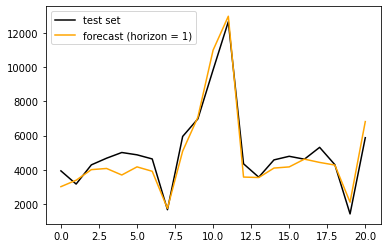

In [38]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


In [39]:
df = sales_df.copy()

# Add lagged values
for month in range(1, 13):
    column_name = f"yt-{month}"
    df[column_name] = df["Sales"].shift(month)

df["avg_12"] = df["Sales"].rolling(window=12).mean()
df["avg_3"] = df["Sales"].rolling(window=3).mean()
df["avg_2"] = df["Sales"].rolling(window=2).mean()
    
# Drop nan
df.replace('NaN', pd.NA, inplace=True)
df.dropna(how='any', inplace=True)


# create df_train and df_test 
df_train = df.query("index < 1971")
df_test = df.query("index >= 1971")

df.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

train_index = df_train.index.values
test_index = df_test.index.values

test_index = np.array(test_index+len(train_index))

# On rajoute une colonne pour les dates (pour pouvoir les afficher sur les graphes)
df["dates"] = sales_df.index.values[-len(df):]



Mean Absolute Prediction Error (MAPE): 0.12628664317472327
Analyse statistique des résultats: 
count       21.000000
mean      4877.708458
std       2502.009796
min       2011.088152
25%       3744.362307
50%       4198.345162
75%       4629.553837
max      12692.050000
dtype: float64


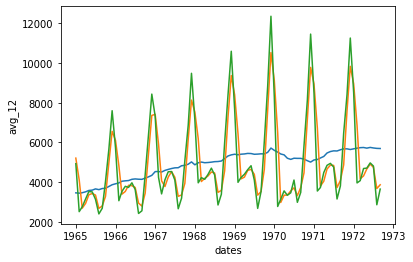

In [41]:
sns.lineplot(x=df["dates"], y=df["avg_12"])
sns.lineplot(x=df["dates"], y=df["avg_3"])
sns.lineplot(x=df["dates"], y=df["avg_2"])

# On entraîne notre modèle en ajoutant nos trois nouvelles colonnes

regr = RandomForestRegressor(n_estimators=20, 
                             max_depth=5, 
                             random_state=42)

X = df.drop(columns=["Sales", "dates"])
y = df["Sales"]

results = evaluate_performance_month_prediction(y.values, test_indexes=test_index,
                                                         predictor=regr, full_X = X.values)

print(f'Mean Absolute Prediction Error (MAPE): {results[2]}')
print(f"Analyse statistique des résultats: \n{pd.Series(results[1]).describe()}")




You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

Mean Absolute Prediction Error (MAPE): 0.12784037598673403
Analyse statistique des résultats: 
count       21.000000
mean      4788.905348
std       2639.241898
min       1851.507500
25%       3448.851518
50%       4198.819709
75%       4502.587389
max      12955.900000
dtype: float64


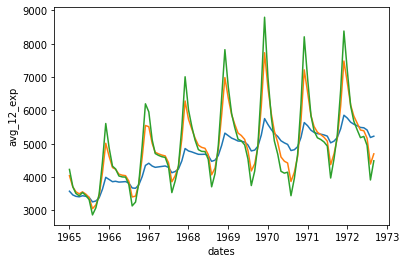

In [42]:
df = sales_df.copy()

# Add lagged values
for month in range(1, 13):
    column_name = f"yt-{month}"
    df[column_name] = df["Sales"].shift(month)

df["avg_12_exp"] = df["Sales"].ewm(halflife=12).mean()
df["avg_3_exp"] = df["Sales"].ewm(halflife=3).mean()
df["avg_2_exp"] = df["Sales"].ewm(halflife=2).mean()
    
# Drop nan
df.replace('NaN', pd.NA, inplace=True)
df.dropna(how='any', inplace=True)


# create df_train and df_test 
df_train = df.query("index < 1971")
df_test = df.query("index >= 1971")

df.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

train_index = df_train.index.values
test_index = df_test.index.values

test_index = np.array(test_index+len(train_index))

# On rajoute une colonne pour les dates (pour pouvoir les afficher sur les graphes)
df["dates"] = sales_df.index.values[-len(df):]


sns.lineplot(x=df["dates"], y=df["avg_12_exp"])
sns.lineplot(x=df["dates"], y=df["avg_3_exp"])
sns.lineplot(x=df["dates"], y=df["avg_2_exp"])

# On entraîne notre modèle en ajoutant nos trois nouvelles colonnes

regr = RandomForestRegressor(n_estimators=20, 
                             max_depth=5, 
                             random_state=42)

X = df.drop(columns=["Sales", "dates"])
y = df["Sales"]

results = evaluate_performance_month_prediction(y.values, test_indexes=test_index,
                                                         predictor=regr, full_X = X.values)

print(f'Mean Absolute Prediction Error (MAPE): {results[2]}')
print(f"Analyse statistique des résultats: \n{pd.Series(results[1]).describe()}")

You should see a better MAPE!

Try to look at the importance of each feature. What do you find?


Feature: yt-1, Score: 0.22606776993982394 %
Feature: yt-2, Score: 1.4187104927740473 %
Feature: yt-3, Score: 0.7486392248593914 %
Feature: yt-4, Score: 0.1899657811886029 %
Feature: yt-5, Score: 0.0976271763448238 %
Feature: yt-6, Score: 0.8750517813029778 %
Feature: yt-7, Score: 0.2166837309566246 %
Feature: yt-8, Score: 0.38672776285948285 %
Feature: yt-9, Score: 0.21312480340326118 %
Feature: yt-10, Score: 1.264180958959638 %
Feature: yt-11, Score: 2.224606560429037 %
Feature: yt-12, Score: 86.69321721191467 %
Feature: avg_12_exp, Score: 1.3914110476658204 %
Feature: avg_3_exp, Score: 2.0977554762730994 %
Feature: avg_2_exp, Score: 1.9562302211286817 %


[Text(0.5, 1.0, 'Importance de chaque feature')]

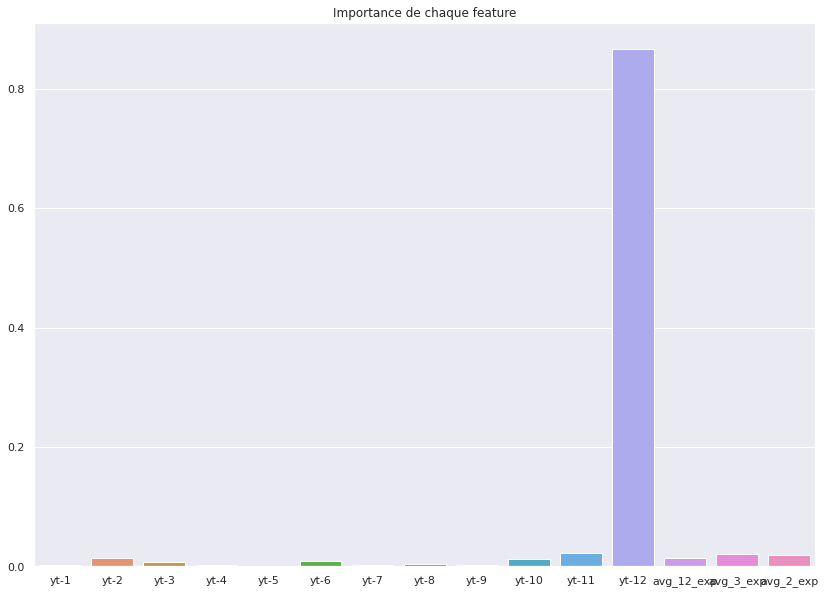

In [53]:
importance = regr.feature_importances_
features = X.columns

for i,j in zip(features, importance):
    print(f"Feature: {i}, Score: {j*100} %")

sns.set(rc={'figure.figsize':(14,10)})
sns.barplot(x=features, y=importance).set(title="Importance de chaque feature")


On constate que le résultat du modèle est surtout influencé par la valeur des ventes 12 mois auparavant. Les autres features semblent n'avoir que peu d'importance.

### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA

In [ ]:
models = []
for count in range(len(df_test)):
    # Créer un set de données avec 